link to git: https://github.com/jonah-gas/Assignment05.git

In [1]:
import os
import numpy as np
import pandas as pd
import requests
import time

os.chdir("C:/Users/johan_nii2lon/OneDrive/Desktop/Data Science Porject Management/Assigements/Assignment 5/Assignment05")

api_key = pd.read_csv("api_key.txt")
 

# Exercise 7+8

In [2]:
#request of venues in germany 
apiconde = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                          params = {"apikey":api_key , "countryCode": "DE", "locale": "*"}).json()

#predefine venues out of lists
venues = apiconde["_embedded"]["venues"]

#get number of entries per page and number of pages
entries = apiconde["page"]["size"]
page = apiconde["page"]["totalPages"]

#extract details of venues and create vectors if no key set to NA
# "for venue in venues" loops over each venue in venues
name = [venue.get("name", "NA") for venue in venues]
city = [venue["city"].get("name", "NA")for venue in venues]
postalCode = [venue.get("postalCode", "NA")for venue in venues]
address = [venue.get("address", {}).get("line1", "NA") for venue in venues]
url = [venue.get("url", "NA") for venue in venues]
location = [venue.get("location", {}) for venue in venues]
longitude = [loc.get("longitude", "NA") for loc in location]
latitude = [loc.get("latitude", "NA")for loc in location]

#create empty dataframe
df = pd.DataFrame({"name": name,
                   "city": city,
                   "postalCode": postalCode,
                   "address": address,
                    "url": url,
                    "longitude": longitude,
                    "latitude": latitude})

#change type of longitude, latitude and postaCode to numeric
df["postalCode"] = pd.to_numeric(df["postalCode"], errors = "coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")

#print head of data frame 
df.head()


,name,city,postalCode,address,url,longitude,latitude
0,Grosse Freiheit 36,Hamburg,22767,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.421380,52.486391
3,Zentrum am Park,Emmelshausen,56281,Rhein-Mosel-Straße 45,https://www.ticketmaster.de/venue/zentrum-am-p...,7.556560,50.155440
4,Stadthalle (Theatersaal),Mülheim,45479,Theodor-Heuss-Platz 1,https://www.ticketmaster.de/venue/stadthalle-t...,6.874710,51.427780


## Exercise 9

In [3]:
#create function to get df for country as input
def df_country(country):
    api_content = requests.get(
        "https://app.ticketmaster.com/discovery/v2/venues/",
        params={
            "apikey": api_key,
            "countryCode": country, "locale": "*", "size" : 500,
        }).json()
    time.sleep(0.2)
    page = api_content["page"]["totalPages"]
    entries = api_content["page"]["size"]
    # create empty df 
    df2 = pd.DataFrame()
    #loop over every page and extract details (see excerise 7+8)
    for i in range(page):
        api_content2 = requests.get(
        "https://app.ticketmaster.com/discovery/v2/venues/",
            params={
            "apikey": api_key,
            "countryCode": country, "locale": "*", "size":500,
            "page":i
            }).json()
        venues = api_content2.get("_embedded", {}).get("venues", [])
    
        name = [venue.get("name", "NA") for venue in venues]
        city = [venue.get("city", {}).get("name", "NA") for venue in venues]
        postalCode = [venue.get("postalCode", "NA") for venue in venues]
        address = [venue.get("address", {}).get("line1", "NA") for venue in venues]
        url = [venue.get("url", "NA") for venue in venues]
        location = [venue.get("location", {}) for venue in venues]
        longitude = [loc.get("longitude", "NA") for loc in location]
        latitude = [loc.get("latitude", "NA") for loc in location]

        df_page = pd.DataFrame({"name": name,
                           "city": city,
                           "postalCode": postalCode,
                           "address": address,
                           "url": url,
                           "longitude": longitude,
                           "latitude": latitude})
        #bind dataframes of all pages together
        df2 = pd.concat([df2, df_page], ignore_index=True)
        
    df2["postalCode"] = pd.to_numeric(df2["postalCode"], errors = "coerce")
    df2["longitude"] = pd.to_numeric(df2["longitude"], errors="coerce")
    df2["latitude"] = pd.to_numeric(df2["latitude"], errors="coerce")
    #return dataframe
    return(df2)
#use function for venues in germany
dfde = df_country("DE")
#df of germany
print(dfde.head(10))
print(dfde.shape)


                       name          city  postalCode                address  \
0        Grosse Freiheit 36       Hamburg     22767.0     Grosse Freiheit 36   
1                 Gruenspan       Hamburg     22767.0     Grosse Freiheit 58   
2         Huxleys Neue Welt        Berlin     10967.0   Hasenheide 107 – 113   
3           Zentrum am Park  Emmelshausen     56281.0  Rhein-Mosel-Straße 45   
4  Stadthalle (Theatersaal)       Mülheim     45479.0  Theodor-Heuss-Platz 1   
5             Schlossgarten      Bruchsal     76646.0       Schloss Bruchsal   
6                Stadthalle    Hockenheim     68766.0        Rathausstraße 3   
7                       FZW      Dortmund     44263.0        Ritterstraße 20   
8               Arena Trier         Trier     54292.0     Fort-Worth-Platz 1   
9             Eissporthalle     Memmingen     87700.0    Hühnerbergstraße 19   

                                                 url  longitude   latitude  
0            http://www.ticketmaster.de/ve

## Exercise 10

<AxesSubplot:>

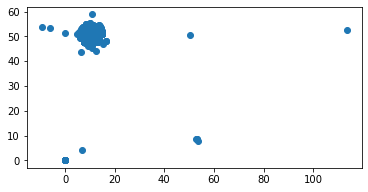

In [4]:
# import package
import geopandas as gpd

#create GeoDataFrame with columns for latitude und longitude
longitude_de = dfde["longitude"]
latitude_de = dfde["latitude"]
dfde_geo = gpd.GeoDataFrame(
    dfde, geometry = gpd.points_from_xy(longitude_de,latitude_de)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot for Germany
map = map[map.name == "Germany"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
dfde_geo.plot(ax = map)

## Exercise 11

<AxesSubplot:>

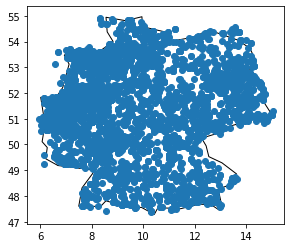

In [5]:
#set values beyond the borders to NA
dfde['longitude'] = np.where((5.866 <= dfde['longitude']) & (dfde['longitude'] <= 15.042), dfde['longitude'], np.nan)
dfde['latitude'] = np.where((47.270 <= dfde['latitude']) & (dfde['latitude'] <= 55.059), dfde['latitude'], np.nan)

#create GeoDataFrame with columns for latitude und longitude
longitude_de = dfde["longitude"]
latitude_de = dfde["latitude"]
dfde_geo = gpd.GeoDataFrame(
    dfde, geometry = gpd.points_from_xy(longitude_de,latitude_de)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot for Germany
map = map[map.name == "Germany"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
dfde_geo.plot(ax = map)

## Exercise 12

                  name               city  postalCode  \
0  The Floor (Rockhal)   Esch-sur-Alzette      4361.0   
1     Parc Gaalgebierg   Esch-sur-Alzette         NaN   
2          Rockhal Box   Esch-sur-Alzette      4361.0   
3    Rockhal Main Hall   Esch-sur-Alzette      4361.0   
4         Rockhal Club   Esch-sur-Alzette      4361.0   
5         Philharmonie    Luxembourg-City         NaN   
6          Herchesfeld   Roeser-Luxemburg      3206.0   
7     Château Beaufort           Beaufort         NaN   
8              Rockhal   Esch-sur-Alzette      4361.0   
9          Casino 2000  Mondorf-Les-Bains         NaN   

                     address  \
0   Avenue du Rock'n'Roll, 5   
1               Rue du Stade   
2   Avenue du Rock'n'Roll, 5   
3   Avenue du Rock'n'Roll, 5   
4   Avenue du Rock'n'Roll, 5   
5       Place de l'Europe, 1   
6                     Roeser   
7             Rue du Château   
8  Avenue du Rock''n''Roll 5   
9      rue Théodore Flammang   

                   

<AxesSubplot:>

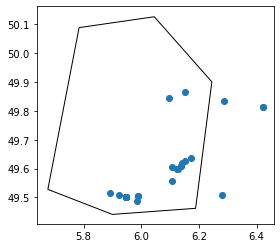

In [6]:
# do the same for luxembourg
dflu = df_country("LU")
print(dflu.head(10))
print(dflu.shape)


#set values beyond the borders to NA
dflu['longitude'] = np.where((5.733333 <= dflu['longitude']) & (dflu['longitude'] <=6.533333), dflu['longitude'], np.nan)
dflu['latitude'] = np.where((49.447778 <= dflu['latitude']) & (dflu['latitude'] <= 50.182944), dflu['latitude'], np.nan)

# create GeoDataFrame with columns for latitude und longitude
longitude_lu = dflu["longitude"]
latitude_lu = dflu["latitude"]
dflu_geo = gpd.GeoDataFrame(
    dflu, geometry = gpd.points_from_xy(longitude_lu,latitude_lu)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot for Germany
map = map[map.name == "Luxembourg"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
dflu_geo.plot(ax = map)

The plot still shows venues outside the borders. As i double checked the values for longitude and latitude this is due to the poor visualization of the borders by geopandas.